In [1]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-paper'])
import numpy as np
import pandas as pd
import json
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
import scipy
import traceback
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True

# Plot TMFG only

In [51]:

workers=[1, 4, 12, 24, 36, 48, 96]# 1 must be first processed

prefixs=[2, 5, 10, 30, 50, 200]

In [52]:
df = pd.read_csv("tmfg_allsteps.csv").dropna(how="all")

## plot decomposition

In [53]:
df["log_n"] = np.log(df["n"])
df["log_time"] = np.log(df["time"])
df["bubble-tree"] = df["bubble_tree"]
df["prefixnum"] = df[[ "prefix"]].astype(float)
df["prefix-str"] = df["prefix"].astype(str)

In [29]:
def plotSteps(df):
    fig, axs = plt.subplots(2,1, figsize=(16,9))
#     sns.set(font_scale=1.6) 
    sns.set_style("whitegrid")
    df[df["workers"]==1].set_index(['prefix']).sort_values('prefixnum', ascending=False)[["tmfg","apsp",'bubble-tree',"hierarchy"]].plot.barh(stacked=True, ax=axs[0])
    df[df["workers"]==96].set_index(['prefix']).sort_values('prefixnum', ascending=False)[["tmfg","apsp",'bubble-tree',"hierarchy"]].plot.barh(stacked=True, ax=axs[1])
    axs[0].set_title("1 thread", fontsize = 30)
    axs[1].set_title("48 cores with two-way hyper-threading", fontsize = 30)

    # axs[0].set_xlabel("time(s)", fontsize = 15)
    axs[1].set_xlabel("runtime (sec)", fontsize = 30)
    axs[1].set_ylabel("Prefix Size", fontsize = 30)
    axs[0].set_ylabel("Prefix Size", fontsize = 30)
    axs[0].legend().set_visible(False)
    
    
    for myax in axs:
        for l in myax.yaxis.get_ticklabels():
            l.set_fontsize(30)
        for l in myax.xaxis.get_ticklabels():
            l.set_fontsize(30)
    # Define some hatches
    hatches = ['/', '\\', '+',  '*', '-', 'x', '.', 'o', 'O', '|']

    # Loop over the bars
    for j in range(2):
        for i,thisbar in enumerate(axs[j].patches):
            thisbar.set_hatch(hatches[i //6])
            
    axs[1].legend(fontsize = 25, facecolor ="white",framealpha=1,frameon = True)
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()

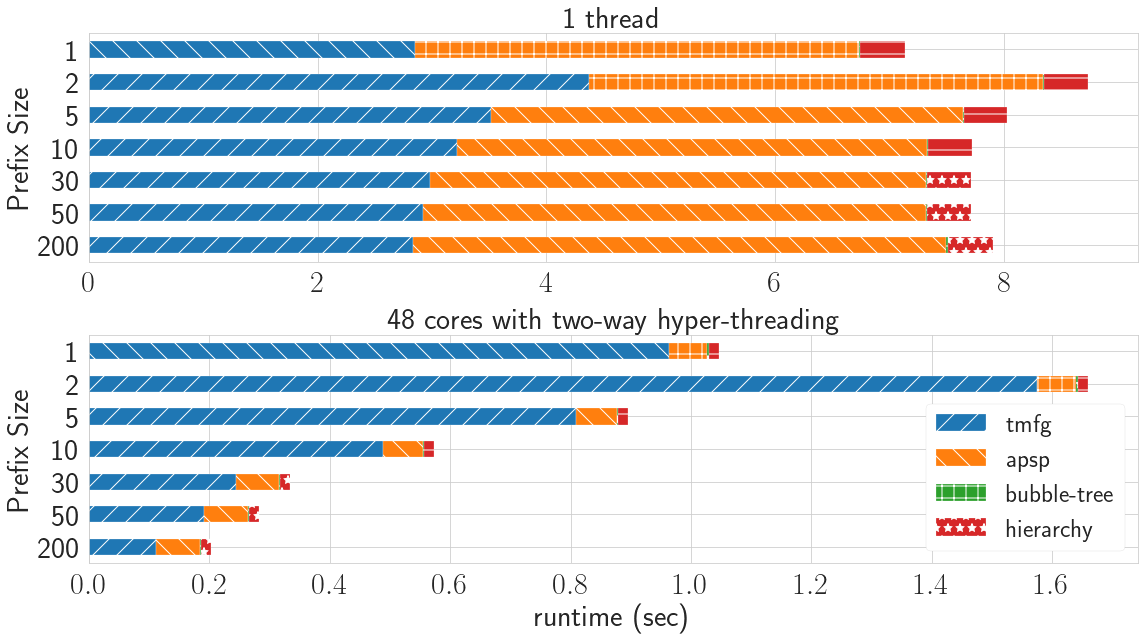

In [30]:
plotSteps(df[(df["dataset"]=="ECG5000")])
plt.savefig("figures/decomposition.pdf" )

## plot scalability

In [44]:
def plot_scalability(step, dataname="ECG5000", name=""):
    fig, ax = plt.subplots(figsize=(10,4))
    sns.set_style("whitegrid")
    ax = sns.lineplot(x = 'workers',
            y = '%sspeedup'%step,
            hue = "prefix-str",
            style = "prefix-str",
            ax = ax, linewidth = 5,
            data=df[df["dataset"]==dataname])
    handles, labels = ax.get_legend_handles_labels()
    labels = np.array(labels).astype(int)
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    labels = np.array(labels).astype(str)
    [ha.set_linewidth(3) for ha in handles ]
    plt.legend(handles, labels, title='Prefix Size', bbox_to_anchor=([1, 1]), fontsize = 20, title_fontsize = 20)
    ax.set_xticks(workers, minor=False)
    yticks = [ 0, 5,10,15,20,25,30]
    ax.set_xlabel("Threads", fontsize = 20)
    ax.set_yticks(yticks, minor=True)
    ax.set_xticks([1,4,12, 24,36,48,96], minor=True)
    ax.set_xticklabels(["1","4","12", "24","36","48","48h"])
    ax.minorticks_on()
    
    for l in ax.yaxis.get_ticklabels():
        l.set_fontsize(20)
    for l in ax.xaxis.get_ticklabels():
        l.set_fontsize(20)
    # Customize the major grid
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    # Customize the minor grid
    ax.grid(which='minor', linestyle=':', linewidth='0.2', color='black', axis="y")
    if name=="":
        name=step
    ax.set_ylabel("%s Speedup" %name, fontsize = 20);
    plt.tight_layout()

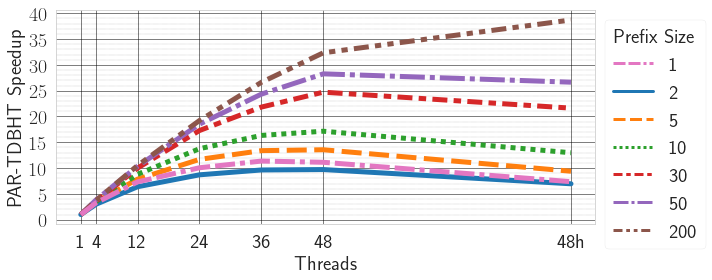

In [45]:
plot_scalability("time", "Crop", "PAR-TDBHT")
plt.savefig("figures/speedup.pdf" )

In [46]:
def getScalability(w, p, ax):
    df_subset = df[(df["workers"]==w)&(df["method"]=="tmfg_%s"%p)].sort_values(by="time")[["time","n"]]
    times = df_subset["time"].to_numpy()
    sizes = df_subset["n"].to_numpy()
    [a,b] = np.polyfit(np.log(sizes), np.log(times), 1)
    print(a,b)
    color = "green"
    sns.lineplot(x=np.log(sizes),y=a*np.log(sizes) + b, ax = ax, color = color, linestyle = "--", 
                 alpha = 0.8,linewidth = 10)
    ax.text(np.min(np.log(sizes)), np.max(a*np.log(sizes) + b)-0.2, "log(y) = %.2flog(x) %.2f" % (a,b), 
            color = color, fontsize = 15)
    print("log(y) = %.2flog(x) %.2f" % (a,b))

2.2237026963228264 -16.751185252991952
log(y) = 2.22log(x) -16.75
1.7975950828927976 -14.669735338678768
log(y) = 1.80log(x) -14.67


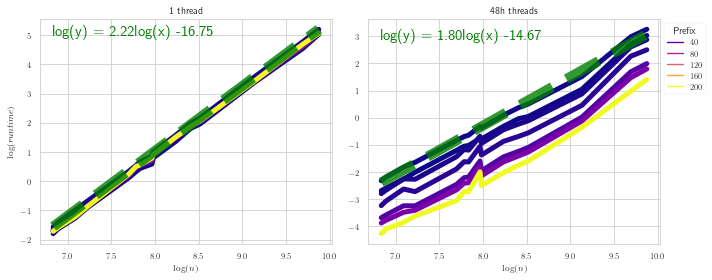

In [54]:
fig, axs = plt.subplots(1,2, figsize=(10,4))

sns.lineplot(x = 'log_n',
            y = 'log_time',
            hue = 'prefix',
            linewidth = 5,
            data=df[(df["workers"]==1) & (df["prefix"].isin([1,2, 5, 10, 30, 50, 200]))], 
            ax = axs[0],
            palette="plasma")
sns.lineplot(x = 'log_n',
            y = 'log_time',
            hue = 'prefix',
            linewidth = 5,
            data=df[(df["workers"]==96) & (df["prefix"].isin([1,2, 5, 10, 30, 50, 200]))], 
            ax = axs[1],
            palette="plasma")
getScalability(1,2, axs[0])
getScalability(96,2, axs[1])

axs[0].legend().set_visible(False)
axs[0].set_ylabel("$\log(runtime)$")
axs[0].set_xlabel("$\log(n)$")
axs[1].set_ylabel("")
axs[1].set_xlabel("$\log(n)$")
axs[1].legend(bbox_to_anchor=(1, 1), title = "Prefix")#
axs[0].set_title("1 thread")
axs[1].set_title("48h threads")
plt.subplots_adjust(left=0.1,right=0.995, top=0.93, bottom=0,wspace=0.2, hspace = 0.1)
plt.tight_layout()